# How to use a Matrix Factorization model in BigQueryML to make movie recommendations

###### Copyright
**GUI Author:** [ Google Cloud](https://cloud.google.com/bigquery-ml/docs/logistic-regression-prediction)<br>
**Notebook Adoption Author:** [Paul Kamau](https://paulkamau.com)<br>
**Project Type:** BQML Matrix Factorization<br>
**Date created:** 2023/26/10<br>
**Training Dataset** This project uses the public dataset [Movielens](http://files.grouplens.org/datasets/movielens/ml-1m.zip)

## Summary
This project used a matrix factorization model in BigQuery ML to generate movie recommendations for a user using the public movielens dataset. This dataset contains explicit feedback data given a movie ID and User ID. The recommendation is based on rating scale (1-5), genre and other metadata info. The user_id and movie_id ratings dataset has 1,000,209 rows. The movie titles dataset has 3,883 rows.

### Dataset
Dataset was retrieved from the grouplens Marketplace of datasets [Movielens](http://files.grouplens.org/datasets/movielens/ml-1m.zip) and the dataset created on BigQuery with the ID: `04_bqml_matrixFactor_movie_recc_prediction` prefix. The data format was originally in csv, so it was first loaded and transformed from the gcs bucket into the BQ table.

This tutorial uses the following Google Cloud data analytics and ML services:

## Key Concepts:
- Matrix Factorization
- ML.RECOMMEND
- ML.WEIGHTS

## Objective
- Create an explicit recommendations model using the CREATE MODEL statement
- Use the ML.EVALUATE function to evaluate the ML Models
- Use the ML.WEIGHTS function to inspect the latent factor weights generated during training
- Use the ML.RECOMMEND function to produce recommendations for a user.

## Steps
- Create the dataset & load the dataset into BQ
- Use the SELECT statement to examine the data
- Use the CREATE MODEL statement to create the explicit recommendation model.
- Use the ML.EVALUATE function to evaluate the model data
- Use the ML.PREDICT function to predict the ratings and make recommendations
- Use the ML.RECOMMEND function to fetch all the ratings for the user-item pairs
- Save the recommendation predictions to a table
- Generate the top 5 recommendations per user.


### What is Matrix Factorization?

Matrix factorization is a **collaborative filtering** technique that relies on factorizing the ratings matrix into two vectors called the user factors and the item factors.

The user factors is a low-dimensional representation of a user_id and the item factors similarly represents an item_id.

**Collaborative filtering** provides a way to generate product recommendations for users, or user targeting for products. The starting point is a table, movielens.ratings, with three columns: a user id, an item id, and the rating that the user gave the product. This table can be sparse -- users don’t have to rate all products. Then, based on just the ratings, the technique finds similar users and similar products and determines the rating that a user would give an unseen product. Then, we can recommend the products with the highest predicted ratings to users, or target products at users with the highest predicted ratings.



## Prepare the Envrionment with Package Installs
1. Install the following packages required to execute this notebook.
1. install the workbench notebook product dependencies
1. Automatically restart kernel after installs

### Import AI Platform and ML libraries

In [ ]:
import os
import sys
# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q google-cloud-bigquery db-dtypes

#### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [3]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Prepare the notebook to run in colab.

In [1]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.
import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

#### Import the Google Cloud SDK packages

In [2]:
import google.cloud.aiplatform as vertex_ai
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import json

from typing import Union  # This module provides runtime support for type hints
from google.cloud import bigquery
from sklearn import metrics
from google.api import httpbody_pb2

print("All imports complete")

All imports complete


#### GCP & BQML Variables

In [45]:
# Project variables
#
# These are the project variable used in this ML Model:
#

PROJECT_ID = "paulkamau" # @param {type:"string"}
BQML_MODEL_TYPE = "MATRIX_FACTORIZATION" #@param ["LINEAR_REG", "LOGISTIC_REG","KMEANS","PCA","MATRIX_FACTORIZATION","AUTOENCODER","AUTOML_REGRESSOR", "AUTOML_CLASSIFIER","BOOSTED_TREE_CLASSIFIER","BOOSTED_TREE_REGRESSOR","RANDOM_FOREST_CLASSIFIER","RANDOM_FOREST_REGRESSOR", "DNN_CLASSIFIER","DNN_REGRESSOR","DNN_LINEAR_COMBINED_CLASSIFIER", "DNN_LINEAR_COMBINED_REGRESSOR","ARIMA_PLUS","TENSORFLOW"]

BQML_MODEL_NAME = "bqml_max_factor_movielens_movie_recc_model"
BQML_JOB_DISPLAY_NAME = BQML_MODEL_NAME + "_job"
BQML_ENDPOINT_NAME = BQML_MODEL_NAME + "_endpoint"

# datasets
BQ_DATASET_NAME = "04_bqml_matrixFactor_movie_recc_prediction"
DATASET_CONTENT = f"{BQ_DATASET_NAME}.movie_titles"
DATASET_USER = f"{BQ_DATASET_NAME}.movielens_1m"
DATASET_RECOMMEND = f"{BQ_DATASET_NAME}.recommend_1m"
BQ_DATASET_VIEW_TABLE= f"{BQ_DATASET_NAME}.input_view"

# bucket details
BUCKET_NAME = "bqml_tutorials"
BUCKET_URI = f"gs://{BUCKET_NAME}/{BQML_MODEL_TYPE}/"
OUTPUTBUCKET = f"gs://bqml_datasets_predictions/{BQML_MODEL_TYPE}/"

# Region
REGION = "us-central1" #@param ["us-central1", "europe-west4", "asia-east1"]

print("All variables set")

All variables set


#### Set the Service account automatically from gcloud

In [4]:
# Get your service account from gcloud
if not IS_COLAB:
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

else:  # IS_COLAB:
    shell_output = ! gcloud projects describe  $PROJECT_ID
    project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
    SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

print("Service Account:", SERVICE_ACCOUNT)

Service Account: 993987777814-compute@developer.gserviceaccount.com


#### Initialize Vertex AI and BigQuery SDKs for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
vertex_ai.init(project=PROJECT_ID, location=REGION)

Create the BigQuery client.

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID)

Use a helper function for sending queries to BigQuery.

In [7]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

### Step 1: Create Your Dataset
BigQuery organizes data tables into units called datasets. These datasets are scoped to your GCP project. Datasets are:

- Collections of “related” tables/views together with labels and description
- Allow storage access control at Dataset level
- Define location of data i.e. multi-regional (US, EU) or regional (asia-northeast1)

[Dataset SDK Reference](https://cloud.google.com/bigquery/docs/datasets-intro)

In [38]:
# check if Dataset exists.
sql_list_dataset_exists = f"""SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = '{BQ_DATASET_NAME}'"""

# Display the sql statement
print(sql_list_dataset_exists)

# execute the sql statement
run_bq_query(sql_list_dataset_exists)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = '04_bqml_matrixFactor_movie_recc_prediction'
Finished job_id: 6d3a5998-0392-4565-9647-e4e1520c52f5
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=04_bqml_matrixFactor_movie_recc_prediction&project=paulkamau


In [39]:
sql_create_dataset = f"""CREATE SCHEMA IF NOT EXISTS `{BQ_DATASET_NAME}`"""

print(sql_create_dataset)

run_bq_query(sql_create_dataset)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

CREATE SCHEMA IF NOT EXISTS `04_bqml_matrixFactor_movie_recc_prediction`
Finished job_id: 365b96e3-ef68-4cf0-aa0f-c2a02ec93053
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=04_bqml_matrixFactor_movie_recc_prediction&project=paulkamau


#### Examine both tables

`DATASET_CONTENT` = Contains the movie titles

`DATASET_USER` = Contains the user ratings


In [40]:
sql_inspect_full_feature_dataset1 = f"""
SELECT *
FROM
 `{DATASET_CONTENT}`
LIMIT
 10;
"""

# Display the sql statement
print(sql_inspect_full_feature_dataset1)

run_bq_query(sql_inspect_full_feature_dataset1)



SELECT *
FROM
 `04_bqml_matrixFactor_movie_recc_prediction.movie_titles`
LIMIT
 10;

Finished job_id: 6a0e8c5e-7218-41b7-9121-f6fef7008b50


,movie_id,movie_title,genre
0,632,Land and Freedom (Tierra y libertad) (1995),War
1,665,Underground (1995),War
2,760,Stalingrad (1993),War
3,777,Pharaoh's Army (1995),War
4,1450,Prisoner of the Mountains (Kavkazsky Plennik) ...,War
5,1927,All Quiet on the Western Front (1930),War
6,2669,Pork Chop Hill (1959),War
7,2670,"Run Silent, Run Deep (1958)",War
8,3066,Tora! Tora! Tora! (1970),War
9,3339,Cross of Iron (1977),War


`DATASET_USER` = Contains the user ratings

In [41]:
sql_inspect_full_feature_dataset2 = f"""
SELECT *
FROM
 `{DATASET_USER}`
LIMIT
 10;
"""

# Display the sql statement
print(sql_inspect_full_feature_dataset2)

run_bq_query(sql_inspect_full_feature_dataset2)



SELECT *
FROM
 `04_bqml_matrixFactor_movie_recc_prediction.movielens_1m`
LIMIT
 10;

Finished job_id: 3c7ecbc8-534a-4c7a-aebe-1fe7e6a47548


,user_id,item_id,rating,timestamp
0,2,1213,2.0,2000-12-31 21:34:18+00:00
1,2,434,2.0,2000-12-31 22:02:54+00:00
2,2,3107,2.0,2000-12-31 22:00:02+00:00
3,2,902,2.0,2000-12-31 21:41:45+00:00
4,2,3256,2.0,2000-12-31 21:57:19+00:00
5,2,3699,2.0,2000-12-31 21:46:13+00:00
6,2,2427,2.0,2000-12-31 21:58:33+00:00
7,2,95,2.0,2000-12-31 22:02:23+00:00
8,2,1090,2.0,2000-12-31 21:36:20+00:00
9,2,1968,2.0,2000-12-31 21:41:21+00:00


### Establish the Model Parameters: `User_ID`, `item_col`, and `criteria`

In [42]:
## All dataset variables
USER_COL = "user_id"
ITEM_COL = "item_id"
CRITERIA = "rating"
DATASET_USER_FEATURES = "user_id,item_id,rating"
DATASET_CONTENT_FEATURES = "movie_id,movie_title,genre"

print('All dataset variables updated')

All dataset variables updated


### Step 3: Use the CREATE MODEL statement to create your Matrix Factorization model.

Next, we created the explicit recommendations model using the movielens data using the query to create the model that was used to predict a rating for every user-item pair.

View the **BQML model** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) reference

In [18]:
#
# Let's check if the model already exists.
# Note: We're tapping into the python notebook's integration with vertex without invoking sql in any way.
#
model = vertex_ai.Model.list(filter = f"display_name={BQML_MODEL_NAME}")

if model:
  print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')
else:
  print("Model doesn't exist")


Review the Model in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_max_factor_movielens_movie_recc_model?project=paulkamau


In [ ]:
#
# Create the training job. this cell may take ~1 min to run
#

sql_train_bqml_model_job = f"""
CREATE MODEL IF NOT EXISTS `{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`
OPTIONS (
  model_type = "{BQML_MODEL_TYPE}",
  user_col = "{USER_COL}",
  item_col = "{ITEM_COL}",
  model_registry = "vertex_ai",
  early_stop = TRUE,
  l2_reg=9.83,
  num_factors=34,
  vertex_ai_model_version_aliases = ['matrix_factorization']
) AS
SELECT
{USER_COL},
{ITEM_COL},
{CRITERIA}
FROM
  `{DATASET_USER}`
"""

print(sql_train_bqml_model_job)

run_bq_query(sql_train_bqml_model_job)

print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/bigquery?referrer=search&project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET_NAME}!3s{BQML_MODEL_NAME}')

In the `OPTIONS` parameter:
* with `model_registry="vertex_ai"`, the BigQuery ML model will automatically be <a href="https://cloud.google.com/vertex-ai/docs/model-registry/model-registry-bqml" target="_blank">registered to Vertex AI Model Registry</a>, which enables you to view all of your registered models and its versions on Google Cloud in one place.

- `l2_reg` = The amount of L2 regularization applied. A type of regularization that penalizes weights in proportion to the sum of the squares of the weights.

- `num_factors` = Specifies the number of latent factors to use for matrix factorization models.

* `vertex_ai_model_version_aliases allows you to set aliases to help you keep track of your model version [Doc](https://cloud.google.com/vertex-ai/docs/model-registry/model-alias)


### Step3b. Use the ML.TRAINING_INFO to see the training iterations and details of the model

The ML.TRAINING_INFO [function](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) allows you to see information about the training iterations of a model. ML.TRAINING_INFO can be run while the CREATE MODEL query is running, or after it is run. If you run a query that contains ML.TRAINING_INFO before the first training iteration is complete, the query returns a Not found error.

In [28]:
# Here's where we're using the bq client because of the additional features to tap into matplotlib.

sql_training_info_model = bq_client.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
        ORDER BY iteration
        """
).to_dataframe()

sql_training_info_model

,training_run,iteration,loss,eval_loss,duration_ms
0,0,0,3.538775,NaN,101157
1,0,1,0.666185,NaN,49707
2,0,2,0.556992,NaN,45537
3,0,3,0.495828,NaN,61460
4,0,4,0.464330,NaN,45510
5,0,5,0.445371,NaN,60751
6,0,6,0.430605,NaN,48677
7,0,7,0.421342,NaN,53558
8,0,8,0.412382,NaN,44099
9,0,9,0.406851,NaN,46868



### **Commentary**:
Using the training data to calculate the loss metric, the model went through **11 iterations** to minimize loss as much as possible with the last iteration having a training Data Loss of 0.3960 and duration of 56 seconds.

Initially, on the first iteration, it had a training Data Loss of 3.53 and a duration of 101 seconds.  The training Data Loss column is considered the Mean Squared Error for all Matrix factorization models.

**Training run**

The value in this column is zero for a newly created model. If you retrain the model using warm_start (new training data), this value is incremented.

**iteration**

The iteration number of the training run. its how many times the model algorithm has attempted to optimize the loss. The value for the first iteration is zero. This value is incremented for each additional training run.

Note: Iterations and epochs are not the same.  *Iterations* is the number of batches (size of data passed) needed to complete one epoch. One Epoch is when an **ENTIRE** dataset is passed forward and backward through the neural network only ONCE.

**loss**

A *loss function* is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

**eval_loss**

The loss metric calculated on the holdout data.

**Learning_rate**

a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

**duration_ms** How long the iteration took, in milliseconds.


### Step3c. Let's take a look at the Loss History

Y axis = loss (high at the beginning. goal is to bring it low)

X axis = eval_loss ()


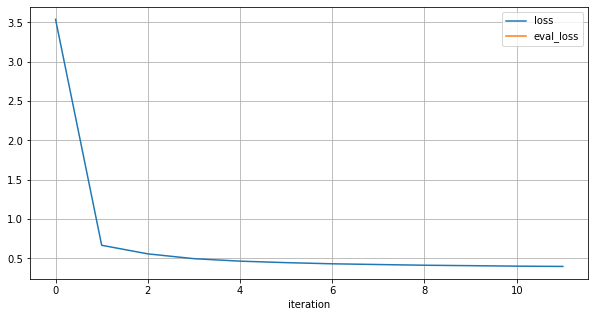

In [43]:
sql_training_info_model.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Step 4: Use the ML.EVALUATE function to evaluate the model data
The ML.EVALUATE function is used to evaluate model metrics. It reports the precision, recall, accuracy, f1_score, log_loss * roc_auc

Machine learning model evaluation metrics are used to

1. assess quality of fit between the model and the data,
2. compare different models, and
3. in the context of model selection, and to predict how accurate each model can be expected to perform on a specific data set.

Read the **BQML ML EVALUATE function** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) reference

In [44]:
sql_evaluate_model = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
"""

print(sql_evaluate_model)

run_bq_query(sql_evaluate_model)


SELECT
  *
FROM
  ML.EVALUATE(MODEL `04_bqml_matrixFactor_movie_recc_prediction.bqml_max_factor_movielens_movie_recc_model`)

Finished job_id: ab9ad55c-7102-4210-b370-d1e5c069b408


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.486514,0.396964,0.025596,0.391139,0.681898,0.681898


Another Query for getting evaluation metrics broken out by test, validate and training sets.


### **Commentary**:
When evaluating model metrics, a rule of thumb is, what does 0 mean, what does 1 mean?

#### **mean_absolute_error**:
MAE (Mean Absolute Error) is the average absolute error between actual and predicted values. [1](https://stephenallwright.com/good-mae-score/)

The lower the value the better and 0 means the model is perfect.

Absolute error, also known as **L1 loss**, is a row-level error calculation where the non-negative difference between the prediction and the actual is calculated.

**MAE** is the aggregated mean of these errors, which helps us understand the model performance over the whole dataset.

*How its calculated* \
<img src="https://stephenallwright.com/content/images/2022/08/mae-definition-pink.png?ezimgfmt=rs:523x230/rscb1" width="300">

**mae** = mean_absolute_error(actual, predicted)

The closer MAE is to 0, the more accurate the model is.

#### **mean_squared_error**:
The lower the value the better and 0 means the model is perfect.

Mean Squared Error (MSE) is the average squared error between actual and predicted values.[2](https://stephenallwright.com/good-mse-value/)

Squared error, also known as **L2 loss**, is a row-level error calculation where the difference between the prediction and the actual is squared. MSE is the aggregated mean of these errors, which helps us understand the model performance over the whole dataset.

The main draw for using MSE is that it squares the error, which results in large errors being punished or clearly highlighted. It’s therefore useful when working on models where occasional large errors must be minimised.

<img src="https://stephenallwright.com/content/images/2022/08/mse-definition-blue.png?ezimgfmt=rs:523x230/rscb1" width="300">


#### **mean_squared_log_error**:
Mean Squared Log Error is the evaluation metrics that computes the ratio of predicted and actual values

The smaller the better.

This is useful when dealing with right skewed targets, since taking the log transform makes the target more normally distributed. In practice it's usually achieved by changing the target to

##### **R2_score**:
R-Squared is a measure of fit where the value ranges from 1, where all variance is explained, to 0 where none of the variance is explained. The higher the R-Squared value the better.

R-Squared is a metric for assessing the performance of regression machine learning models. Unlike other metrics, such as MAE or RMSE, it is not a measure of how accurate the predictions are, but instead a measure of fit. R-Squared measures how much of the dependent variable variation is explained by the independent variables in the model. [3](https://stephenallwright.com/good-r-squared-value/)


<img src="https://stephenallwright.com/content/images/2022/08/r-squared-definition.png?ezimgfmt=rs:523x230/rscb1" width="300">



##### **explained_variance**:
The number of principal components is selected such that the percentage of variance explained by the principal components is greater than the ratio specified by this argument.

The smaller the better.

There are various metrics for Matrix Factorization and other model types (full list of metrics can be found in the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output" target="_blank">documentation</a>).

### Step 5: Use the `ML.RECOMMEND` function to predict ratings using your model

Finally, you use the `ML.RECOMMEND` does not need to take any additional arguments besides the model, but can take in an optional table.

In [35]:
# We are using the remainder of our data ot perform predictions by limiting the dataframe to "PREDICTION". About 3142 rows.

sql_ml_recommend = f"""

SELECT * FROM
 ML.RECOMMEND (MODEL `{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
 where user_id = 1536
 limit 10

"""
print(sql_ml_recommend)

run_bq_query(sql_ml_recommend)



SELECT * FROM
 ML.RECOMMEND (MODEL `04_bqml_matrixFactor_movie_recc_prediction.bqml_max_factor_movielens_movie_recc_model`)
 where user_id = 1536
 limit 10


Finished job_id: e4cc8e04-1aae-42ce-a184-2a7dd2214ea4


,predicted_rating,user_id,item_id
0,4.782743,1536,536
1,3.295425,1536,3597
2,4.166948,1536,2580
3,3.021081,1536,3857
4,4.083758,1536,1303
5,3.707790,1536,2567
6,5.396894,1536,1310
7,4.105408,1536,2078
8,4.634110,1536,1299
9,5.050978,1536,3101



### **Commentary**:
The top-most SELECT statement retrieves the `user`, `item`, and `predicted_rating` column. This last column is generated by the ML.RECOMMEND function.

When you use the ML.RECOMMEND function, the output column name for the model is predicted_<rating_column_name>. For explicit matrix factorization models, predicted_rating is the estimated value of rating.


### Step 6: Generate & Save the Recommendations

Using the previous recommendations query, we can order by the predicted rating and output the top predicted items for each user.

The following query joins the `item_ids` with the `movie_ids` found in the `movielens.movie_titles` table uploaded earlier and outputs the top 5 recommended movies per user.


In [48]:
##
# Save the recommendations in a table
##
sql_ml_recommend_table = f"""

CREATE OR REPLACE TABLE `{DATASET_RECOMMEND}`
OPTIONS() AS
SELECT
*
FROM
ML.RECOMMEND(MODEL `{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)

"""
print(sql_ml_recommend_table)

run_bq_query(sql_ml_recommend_table)




CREATE OR REPLACE TABLE `04_bqml_matrixFactor_movie_recc_prediction.recommend_1m`
OPTIONS() AS
SELECT
*
FROM
ML.RECOMMEND(MODEL `04_bqml_matrixFactor_movie_recc_prediction.bqml_max_factor_movielens_movie_recc_model`)


Finished job_id: 82e92a83-5bff-465e-bc3c-2420aeaa90bd


""


In [51]:
##
#  generate recommendations
##

sql_ml_top_recommendations = f"""
 SELECT
  {USER_COL},
  ARRAY_AGG(STRUCT(movie_title, genre, predicted_rating)
ORDER BY predicted_rating DESC LIMIT 5)
FROM (
SELECT
  user_id,
  item_id,
  predicted_rating,
  movie_title,
  genre
FROM
  `{DATASET_RECOMMEND}`
JOIN
   `{DATASET_CONTENT}`
ON
  {ITEM_COL} = movie_id)
GROUP BY
  {USER_COL}
"""
print(sql_ml_top_recommendations)

run_bq_query(sql_ml_top_recommendations)


 SELECT
  user_id,
  ARRAY_AGG(STRUCT(movie_title, genre, predicted_rating)
ORDER BY predicted_rating DESC LIMIT 5)
FROM (
SELECT
  user_id,
  item_id,
  predicted_rating,
  movie_title,
  genre
FROM
  `04_bqml_matrixFactor_movie_recc_prediction.recommend_1m`
JOIN
   `04_bqml_matrixFactor_movie_recc_prediction.movie_titles`
ON
  item_id = movie_id)
GROUP BY
  user_id

Finished job_id: 07002727-563b-47b6-8053-babd6415a1b5


,user_id,f0_
0,5903,"[{'movie_title': 'Funny Bones (1995)', 'genre'..."
1,537,"[{'movie_title': 'Mad Love (1995)', 'genre': '..."
2,2592,"[{'movie_title': 'Assignment, The (1997)', 'ge..."
3,304,[{'movie_title': 'Life and Times of Hank Green...
4,4400,"[{'movie_title': 'Song of Freedom (1936)', 'ge..."
...,...,...
6035,3132,"[{'movie_title': 'Song of Freedom (1936)', 'ge..."
6036,4447,"[{'movie_title': 'Song of Freedom (1936)', 'ge..."
6037,2909,"[{'movie_title': 'Whole Wide World, The (1996)..."
6038,4749,"[{'movie_title': 'Song of Freedom (1936)', 'ge..."


### Commentary
Using the previous recommendations query, we can order by the predicted rating and output the top predicted items for each user. The following query joins the `item_ids` with the `movie_ids` found in the movielens.movie_titles table uploaded earlier and outputs the top 5 recommended movies per user.



### Step 8 USE ML.PREDICT to make recommendations

With the trained model, we can now provide recommendations. For example, let’s find the best comedy movies to recommend to the user whose userId is 903. In the query below, we are calling ML.PREDICT passing in the trained recommendation model and providing a set of movieId and userId to carry out the predictions on. In this case, it’s just one userId (903), but all movies whose genre includes Comedy.

In [ ]:
##
#  generate 5 predictions for a specific user ID = 903
##

sql_ml_user_recommendations = f"""
SELECT * FROM
ML.PREDICT(MODEL `{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`, (
  SELECT
    movie_id, movie_title, user_id
  FROM `{DATASET_CONTENT}`
  WHERE genre = 'Comedy'
  and user_id = 903
))
ORDER BY predicted_rating DESC
LIMIT 5
"""
print(sql_ml_user_recommendations)

run_bq_query(sql_ml_user_recommendations)

### Step 9: Use Vertex Endpoints for Online Predictions

Endpoints are machine learning models made available for online prediction requests. Endpoints are useful for timely predictions from many users (for example, in response to an application request). You can also request batch predictions if you don't need immediate results.

While BigQuery ML supports batch prediction with <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict" target="_blank">ML.PREDICT</a> and <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a>, BigQuery ML is not suitable for real-time predictions where you need low latency predictions with potentially high frequency of requests.

In other words, deploying the BigQuery ML model to an endpoint enables you to do online predictions.


#### Inspect the model on Vertex AI Model Registry

When the model was trained in BigQuery ML, the line `model_registry="vertex_ai"` registered the model to Vertex AI Model Registry automatically upon completion.

You can view the model on the <a href="https://console.cloud.google.com/vertex-ai/models" target="_blank">Vertex AI Model Registry page</a>, or use the code below to check that it was successfully registered:

In [ ]:
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)
print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')

print(model.gca_resource)



### Create the Endpoint

To deploy your model to an endpoint, you will first need to create an endpoint before you deploy the model to it.

In [52]:
# create an endpoint if it doesn't exist
endpoints = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].display_name}")
else:
    endpoint = vertex_ai.Endpoint.create(
    display_name=BQML_ENDPOINT_NAME,
    location=REGION,
    project=PROJECT_ID,
    )
    print(f"Endpoint Created: {endpoint.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

print(endpoint.display_name)
print(endpoint.resource_name)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/993987777814/locations/us-central1/endpoints/5708088227320037376/operations/2355396692607500288


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/993987777814/locations/us-central1/endpoints/5708088227320037376/operations/2355396692607500288


Endpoint created. Resource name: projects/993987777814/locations/us-central1/endpoints/5708088227320037376


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/993987777814/locations/us-central1/endpoints/5708088227320037376


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/993987777814/locations/us-central1/endpoints/5708088227320037376')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/993987777814/locations/us-central1/endpoints/5708088227320037376')


Endpoint Created: bqml_max_factor_movielens_movie_recc_model_endpoint
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/5708088227320037376?project=paulkamau
bqml_max_factor_movielens_movie_recc_model_endpoint
projects/993987777814/locations/us-central1/endpoints/5708088227320037376


#### Deploy model to Vertex endpoint

With the new endpoint, you can now deploy your model.

In [56]:
model.deploy(endpoint=endpoint)

Deploying model to Endpoint : projects/993987777814/locations/us-central1/endpoints/5708088227320037376


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/993987777814/locations/us-central1/endpoints/5708088227320037376


Using default machine_type: n1-standard-2


INFO:google.cloud.aiplatform.models:Using default machine_type: n1-standard-2


Deploy Endpoint model backing LRO: projects/993987777814/locations/us-central1/endpoints/5708088227320037376/operations/711582828617269248


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/993987777814/locations/us-central1/endpoints/5708088227320037376/operations/711582828617269248


Endpoint model deployed. Resource name: projects/993987777814/locations/us-central1/endpoints/5708088227320037376


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/993987777814/locations/us-central1/endpoints/5708088227320037376


resource name: projects/993987777814/locations/us-central1/endpoints/5708088227320037376

In [53]:
# deploying the model to the endpoint may take 10-15 minutes
# Check if Model Deployment Exists
deployments = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if deployments:
    deployment = deployments[0]
    print(f"Deployment Exists: {deployments[0].display_name}")
else:
    model.deploy(endpoint=endpoint)
    print(f"Model deployment Created: {endpoint.display_name}")

Deployment Exists: bqml_max_factor_movielens_movie_recc_model_endpoint


You can also check on the status of your model by visiting the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>.

### Step 9: Make online predictions to the endpoint

Using a sample of the training data, you can test the endpoint to make online predictions.

In [ ]:
df_sample_requests_list = [
    {
        "age": 45,
        "workclass": "Public",
        "marital_status": "Single",
        "education_num": 6,
        "occupation": "Exec-managerial",
        "hours_per_week": 40,
    }
]

In [ ]:
prediction = endpoint.predict(df_sample_requests_list)
print(prediction)

You can then extract the predictions from the prediction response

In [ ]:
# to view the prediction for the first row
prediction.predictions[1]['prediction']

## Cleaning up

To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Undeploy model from endpoint and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete BigQuery dataset, including the BigQuery ML model
! bq rm -r -f $PROJECT_ID:$BQ_DATASET_NAME